In [7]:
%matplotlib inline

import matplotlib as mpl

mpl.rc('figure', figsize=(10, 6))

# Transformer and BERT

- Vaswani et al., [Attention is All you Need.](https://papers.nips.cc/paper/7181-attention-is-all-you-need) NIPS 2017: 5998-6008
- Devlin et al., [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.](https://www.aclweb.org/anthology/N19-1423/) NAACL-HLT (1) 2019: 4171-4186

---

- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
- [The Illustrated BERT, ELMo ...](https://jalammar.github.io/illustrated-bert/)
- [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)

---

This last part of the tutorial is about a new network architechture called the Transformer and a specific version of that called BERT. I'm not going to go through the transformer architechture in detail as there are already plenty of resources that do so, some in excruciating detail (see links). Instead, I'm going to cover two specific aspects of the architecture that I found rather unintuitive or was unable to find satisfactory explanations for elsewhere: the specific attention model of BERT and the input encoding that is used.

There's going to be some slides and some code examples and right in the end I'll show some real world results from the data from where I work.

![](./homer_reading.gif) ![](homer_cooking.gif)

But first, please bare with me for a short digression about language. I think it's important to understand what these deep networks are meant to be learning versus what they may or may not be learning.

If you find this digression unbearable I hope you'll at least enjoy the animated history of me trying to understand the BERT.

---

Computational linguistics as a field has relatively recently moved drastically away from explicit representation of meaning towards implicit, learned representations. One example of this is word vectors or embeddings that aim to encode distributional similarity and facilitate distributional composition. So for instance, you take embedding for "red" and the embedding for "car" put them together and you get something that should be similar to say "ferrari".

![A Ferrari](ferrari-miniature-red-35964.jpg)

This is extremely convenient as it gives you arithmetic tools to work with "meaning", but it's also just single units (words) not larger collections like documents etc. Word vectors are not the only way to represent or encode meaning.

In [12]:
import spacy
nlp = spacy.load('en')

In [13]:
doc = nlp("PyData Berlin is lovely group.")
spacy.displacy.render(doc, style='dep')

In [14]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from([('groups', 'lovely', {'label': 'amod'}),
                  ('music', 'lovely', {'label': 'amod'}),
                  ('gesture', 'lovely', {'label': 'amod'}),
                  ('music', 'blue', {'label': 'amod'}),
                  ('music', 'loud', {'label': 'amod'}),
                  ('people', 'old', {'label': 'amod'}),
                  ('people', 'young', {'label': 'amod'}),
                 ])

# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.shell_layout(G, scale=15)

edge_labels = dict([((u, v), d['label'])
                    for u, v, d in G.edges(data=True)])

/Users/mattilyra/.local/share/virtualenvs/pydatanyc_2019-b2AkOBOU/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/mattilyra/.local/share/virtualenvs/pydatanyc_2019-b2AkOBOU/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


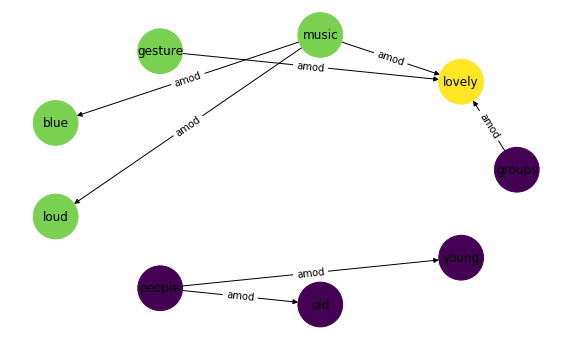

In [15]:
val_map = {'lovely': 1.0, 'music': 0.8, 'gesture': 0.8, 'blue': 0.8, 'loud': 0.8,}
values = [val_map.get(node, 0.0) for node in G.nodes()]
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw(G, pos, node_size=2000, node_color=values)

<sub>Weir et al. [Aligning Packed Dependency Trees: A Theory of Composition for Distributional Semantics.](https://www.aclweb.org/anthology/J16-4006/) Computational Linguistics 42(4): 727-761 (2016)</sub>

<sub>Kober et al. [Improving Semantic Composition with Offset Inference.](https://aclweb.org/anthology/P17-2069/) ACL (2) 2017: 433-440</sub>

![Clever Bert](clever_bert.jpg)
- https://thegradient.pub/nlps-clever-hans-moment-has-arrived/
- https://thegradient.pub/frontiers-of-generalization-in-natural-language-processing/

So why am I talking about all of this? Because the way we test models of distributional semantics or distributional composition, like word vectors or APTs, or larger language models are themselves biased and don't account for the totality of language.

The exercise then is not about "understanding" language as such, but improving performance at some specific end task, maybe that task is machine translation or maybe it's sequence labelling. 

# Transformer and BERT

<center>
    <img src=transformer_overview.png alt="The Transformer" />
</center>

<sub>Vaswani et al., Attention is All you Need. NIPS 2017: 5998-6008</sub>

Sequence models like LSTMs or GRUs have a number of limitations that have become problematic for a number of reasons over the years:

- very long sequences can lead to exploding or vanishing gradients and possibly forgetting
- the recurrent architecture itself is not particularly well suited to modern hardware making RNNs expensive to train and operate

while the former has been addressed to some extent by Bidirectional LSTM networks there is no easy way to solve the second problem.

To resolve some of these issues the `Transformer` model was proposed by Vaswani et al. The model exclusively uses attention mechanisms to process sequence data and it is highly parallelisable.

- _Vaswani et al., [Attention is All you Need.](https://papers.nips.cc/paper/7181-attention-is-all-you-need) NIPS 2017: 5998-6008_
- _Devlin et al., [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.](https://www.aclweb.org/anthology/N19-1423/) NAACL-HLT (1) 2019: 4171-4186_

---

- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
- [The Illustrated BERT, ELMo ...](https://jalammar.github.io/illustrated-bert/)
- [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)

---

<center>
    <img src=transformer_input.png alt="The Transformer Input Stage" />
</center>

# Byte Pair Encoding

- Sennrich et al., [Neural Machine Translation of Rare Words with Subword Units](https://aclweb.org/anthology/P16-1162/) ACL (1) 2016

<sub>"The main motivation ... is that the translation of some words is transparent ... even if they are novel ... based on translation of known subword units such as morphemes or phonemes."</sub>

<img src=finnish.jpg height=70% />

    ajaa                 = to drive
    ajaja                = driver

    ajattaa              = to make someone drive
    ajatuttaa            = to make someone make drive
    ajatatuttaa          = to make someone make someone make drive

    ajan                 = I drive
    ajaisinkohan         = I wonder if I should drive
    ajelisinkohankaan    = I wonder if I should even be driving
    ajella               = to drive casually
    ajelutteliskohankaan = I wonder if I should even make someone drive casually

    ajastaa              = to time

![Kuusi Palaa](kuusi_palaa.jpg)

### hängen = hang, fahren = drive

### erhängen = to hang yourself, erfahren = experience

### verhängen = impose, fine, verfahren = proceed

### tract, attract, subtract (??)

In [9]:
from typing import List
from itertools import zip_longest, cycle, chain

def align_token_idx(tokens: List[str]) -> str:
    idx = (f'{i:^8}' for i, _ in enumerate(tokens))
    idx_batches = zip_longest(*[iter(idx)]*8, fillvalue='')
    tokens = (f'{s:^8}' for i, s in enumerate(tokens))
    token_batches = zip_longest(*[iter(tokens)]*8, fillvalue='')
    sep = ''
    s = f'\n{sep:^64}\n'.join('\n'.join((''.join(idx), ''.join(toks))) 
                              for idx, toks in zip(idx_batches, token_batches))
    return s

In [16]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [17]:
print(align_token_idx(tokenizer.tokenize('The BERT tokenizer.')))

   0       1       2       3       4       5       6    
  The      BE     ##RT    tok    ##eni   ##zer     .    


In [135]:
print(align_token_idx(tokenizer.tokenize('The Berlin philharmonics.')))

   0       1       2       3       4       5       6    
  The    Berlin   phi    ##lha   ##rmon  ##ics     .    


In [136]:
print(align_token_idx(tokenizer.tokenize('The BER airport will open soon.')))

   0       1       2       3       4       5       6       7    
  The      BE     ##R   airport   will    open    soon     .    


In [131]:
print(align_token_idx(tokenizer.tokenize('I bought a coffee yesterday (5.11.2019) for 6.17$.')))

   0       1       2       3       4       5       6       7    
   I     bought    a     coffee    ye    ##ster  ##day     (    
                                                                
   8       9       10      11      12      13      14      15   
   5       .       11      .      2019     )      for      6    
                                                                
   16      17      18      19   
   .       17      $       .    


So let's load the BERT multilingual tokenizer and see what the tokenised text looks like in practice.

Notice that BERT is split in two, similar to how BER is split in two.

You as a user of this framework need to make a decision what to do with the subwords. Do you ignore them, keep them, downweight them? But, we're getting ahead of ourselves - attention!

# Attention

- [Augmented RNNs](https://distill.pub/2016/augmented-rnns/)
- Lilian Weng [Attention Attention](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)

<center>
    <img src=transformer_input.png alt="The Transformer Input Stage" />
</center>

## BERT's Attention Model (self attention)

_"Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence."_ *

_"We call __our particular attention__ "Scaled Dot-Product Attention ..."_ *

<sub>* Vaswani et al., [Attention is All you Need.](https://papers.nips.cc/paper/7181-attention-is-all-you-need) NIPS 2017: 5998-6008</sub>

## Context in RNNs

![](RNN-unrolled.png)

<sub>Chris Olah [Understanding LSTM networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)</sub>

## Context in the Transformer
$$ Attention(Q, V, K) = softmax(\frac{QK^T}{\sqrt{d_k}})V $$

![](self-attention-matrix-calculation-2.png)

<sub>Jay Alammar [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)</sub>

Let's pause here for a bit and think about what these matrix operations represent. The terms "query", "key" and "value" are somehow reminiscent of information retrieval so let's use that as an analogy.

In information retrieval you normally have a some documents and a user query. Documents in the index are ranked based on how well they match the query. The ranking is based on some "compatibility function" (BM25).

                    LOC     LOC    LOC
           The new Berlin airport (BER) will open soon.
 
 
                                            LOC    LOC
                                            org    dst
           ... please book me a flight from BER to MUC for tomorrow

----

# DEMO

In [14]:
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [15]:
token_ids = tokenizer.encode('The new Berlin airport (BER) will open soon.')
token_ids

[1996, 2047, 4068, 3199, 1006, 2022, 2099, 1007, 2097, 2330, 2574, 1012]

In [16]:
tokenizer.convert_ids_to_tokens(token_ids)

['the',
 'new',
 'berlin',
 'airport',
 '(',
 'be',
 '##r',
 ')',
 'will',
 'open',
 'soon',
 '.']

----

In [11]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups(data_home='./data', subset='train', remove=('headers', 'footers', 'quotes'))
data_test = fetch_20newsgroups(data_home='./data', subset='test', remove=('headers', 'footers', 'quotes'))

In [4]:
from transformers import BertTokenizer

def map_label(label_idx):
    return data['target_names'][label_idx].split('.')[0]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X, y = zip(*[([tokenizer.cls_token_id] + tokenizer.encode(x) + [tokenizer.sep_token_id], map_label(y_idx))
             for x, y_idx in zip(data['data'], data['target'])])
label_map = {label: idx for idx, label in enumerate(set(y))}
y = [label_map[y_] for y_ in y]

Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (836 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3224 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (792 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

KeyboardInterrupt: 

In [5]:
from transformers import BertTokenizer

def map_label(label_idx):
    return data['target_names'][label_idx].split('.')[0]

def tokenize(doc, tokenizer):
    tokens = tokenizer.tokenize(doc)[:510]
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    if len(token_ids) < 510:
        token_ids = token_ids + [0] * (510 - len(token_ids))
    return token_ids

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

X_train, y_train = zip(*[([tokenizer.cls_token_id] + tokenize(x, tokenizer) + [tokenizer.sep_token_id],
                          map_label(y_idx))
                         for x, y_idx in zip(data['data'], data['target'])])
label_map = {label: idx for idx, label in enumerate(set(y_train))}
y_train = [label_map[y_] for y_ in y_train]

In [7]:
import torch
from torch.utils.data import TensorDataset, RandomSampler, DataLoader

X_train = torch.LongTensor(X_train)
y_train = torch.LongTensor(y_train)

batch_size = 8
data_train = TensorDataset(X_train, y_train)
sampler = RandomSampler(data_train)
train_dataloader = DataLoader(data_train, sampler=sampler, batch_size=8)

In [8]:
from transformers.optimization import WarmupLinearSchedule
from transformers import BertForSequenceClassification
from transformers import AdamW

num_epochs = 5
bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(torch.unique(y_train)))
params = [p for n, p in bert.named_parameters() if 'classifier.' in n]
optimizer = AdamW(params, lr=3e-5, correct_bias=False)

num_total_steps = num_epochs * (len(train_dataloader.sampler)
                              // batch_size)
num_warmup_steps = int(num_total_steps * 0.15)
scheduler = WarmupLinearSchedule(optimizer,
                                 warmup_steps=num_warmup_steps,
                                 t_total=num_total_steps)

In [9]:
import torch
torch.cuda.is_available()

True

In [10]:
from tqdm import tqdm_notebook as tqdmn
from torch.nn.utils import clip_grad_norm_

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert.to(DEVICE)

for _ in tqdmn(range(num_epochs), total=num_epochs, desc="Epoch"):
    steps = tqdmn(train_dataloader,
                  total=X_train.size()[0] // train_dataloader.batch_size + 1,
                  desc='Mini-batch')
    train_loss = 0
    for i_step, batch in enumerate(steps):
        batch_X, batch_y = (b.to(DEVICE) for b in batch)
        loss, *_ = bert(batch_X, labels=batch_y)
        train_loss += loss.item()
        loss.backward()
        clip_grad_norm_(bert.parameters(), 1.0)
        steps.set_postfix_str(f'avg. loss {train_loss / (i_step + 1):.4f}')
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

In [15]:
bert.to('cpu')
torch.save(bert.to('cpu'), 'bert-20news-5epochs-HEAD.pt')

In [16]:
del batch_X, batch_y

In [17]:
torch.cuda.empty_cache()

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

X_test, y_test = zip(*[([tokenizer.cls_token_id] + tokenize(x, tokenizer) + [tokenizer.sep_token_id],
                         map_label(y_idx))
                        for x, y_idx in zip(data_test['data'], data_test['target'])])
label_map = {label: idx for idx, label in enumerate(set(y_test))}
y_test = [label_map[y_] for y_ in y_test]

In [19]:
from torch.utils.data import SequentialSampler
from torch.nn import functional as F

X_test = torch.LongTensor(X_test)

batch_size = 4
data_test = TensorDataset(X_test)
sampler = SequentialSampler(data_test)
test_dataloader = DataLoader(data_test, sampler=sampler, batch_size=batch_size)

bert.eval()
bert.to(DEVICE)
pred = []
for x, *_batch in test_dataloader:
    x = x.to(DEVICE)
    pred_, *_ = bert(x)
    _, pred_ = F.log_softmax(pred_, dim=1).exp().max(dim=1)
    pred.extend(pred_.cpu().numpy().tolist())

In [20]:
from sklearn import metrics

print(metrics.classification_report(y_test, pred, target_names=list(label_map.keys())))

              precision    recall  f1-score   support

         soc       0.00      0.00      0.00       398
         rec       0.00      0.00      0.00      1590
         alt       0.05      0.08      0.06       319
         sci       0.00      0.00      0.00      1579
        misc       0.00      0.00      0.00       390
        talk       0.30      0.18      0.22      1301
        comp       0.27      0.87      0.42      1955

    accuracy                           0.26      7532
   macro avg       0.09      0.16      0.10      7532
weighted avg       0.12      0.26      0.15      7532



/home/ubuntu/.local/share/virtualenvs/pydatanyc_2019-QOOn-cei/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---

In [23]:
print([g_.size() for g in optimizer.param_groups for g_ in g['params']])

[torch.Size([7, 768]), torch.Size([7])]


In [21]:
import torch
from torch.nn.utils import clip_grad_norm_

from transformers.optimization import WarmupLinearSchedule
from transformers import BertForSequenceClassification
from transformers import AdamW

from tqdm import tqdm_notebook as tqdmn

num_epochs = 5
bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(torch.unique(y_train)))
params = [p for n, p in bert.named_parameters()]  # if .classifier in n]
optimizer = AdamW(params, lr=3e-5, correct_bias=False)

num_total_steps = num_epochs * (len(train_dataloader.sampler)
                              // batch_size)
num_warmup_steps = int(num_total_steps * 0.15)
scheduler = WarmupLinearSchedule(optimizer,
                                 warmup_steps=num_warmup_steps,
                                 t_total=num_total_steps)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert.to(DEVICE)

for _ in tqdmn(range(num_epochs), total=num_epochs, desc="Epoch"):
    steps = tqdmn(train_dataloader,
                  total=X_train.size()[0] // train_dataloader.batch_size + 1,
                  desc='Mini-batch')
    train_loss = 0
    for i_step, batch in enumerate(steps):
        batch_X, batch_y = (b.to(DEVICE) for b in batch)
        loss, *_ = bert(batch_X, labels=batch_y)
        train_loss += loss.item()
        loss.backward()
        clip_grad_norm_(bert.parameters(), 1.0)
        steps.set_postfix_str(f'avg. loss {train_loss / (i_step + 1):.4f}')
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

In [22]:
bert.to('cpu')
torch.save(bert.to('cpu'), 'bert-20news-5epochs-ALL.pt')

In [23]:
torch.cuda.empty_cache()

In [24]:
from torch.utils.data import SequentialSampler
from torch.nn import functional as F

X_test = torch.LongTensor(X_test)

batch_size = 4
data_test = TensorDataset(X_test)
sampler = SequentialSampler(data_test)
test_dataloader = DataLoader(data_test, sampler=sampler, batch_size=batch_size)

bert.eval()
bert.to(DEVICE)
pred = []
for x, *_batch in test_dataloader:
    x = x.to(DEVICE)
    pred_, *_ = bert(x)
    _, pred_ = F.log_softmax(pred_, dim=1).exp().max(dim=1)
    pred.extend(pred_.cpu().numpy().tolist())

In [25]:
from sklearn import metrics

print(metrics.classification_report(y_test, pred, target_names=list(label_map.keys())))

              precision    recall  f1-score   support

         soc       0.55      0.70      0.61       398
         rec       0.82      0.69      0.75      1590
         alt       0.02      0.08      0.03       319
         sci       0.21      0.09      0.12      1579
        misc       0.81      0.55      0.65       390
        talk       0.63      0.58      0.60      1301
        comp       0.79      0.85      0.82      1955

    accuracy                           0.55      7532
   macro avg       0.54      0.51      0.51      7532
weighted avg       0.60      0.55      0.57      7532



In [38]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause
from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(tol=1e-3)),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

def map_label(label_idx):
    return data['target_names'][label_idx].split('.')[0]

y_names = list(map(map_label, data.target))
label_map = {label: idx for idx, label in enumerate(set(y_names))}
y = [label_map[y_] for y_ in y_names]

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=3, verbose=1)

grid_search.fit(data.data, y)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:  4.4min finished


done in 1630.918s

Best score: 0.827
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 20
	clf__penalty: 'elasticnet'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In [39]:
data_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
y_test = [label_map[map_label(y_)] for y_ in data_test.target]

In [19]:
from sklearn import metrics

In [41]:
print(metrics.classification_report(y_test,
                                    grid_search.best_estimator_.predict(data_test.data),
                                    target_names=list(label_map.keys())))

              precision    recall  f1-score   support

        comp       0.84      0.87      0.86      1955
         soc       0.73      0.71      0.72       398
        talk       0.74      0.77      0.75      1301
         sci       0.78      0.73      0.76      1579
        misc       0.82      0.76      0.79       390
         rec       0.79      0.86      0.83      1590
         alt       0.62      0.41      0.49       319

    accuracy                           0.79      7532
   macro avg       0.76      0.73      0.74      7532
weighted avg       0.79      0.79      0.79      7532

